In [4]:
import os
import biom
import warnings
import numpy as np
import pandas as pd
import qiime2 as q2
from Bio import SeqIO
from qiime2 import Artifact
from qiime2 import Metadata
from skbio import OrdinationResults
from skbio.stats.distance import permanova, anosim
from skbio.stats.distance import DistanceMatrix
from qiime2.plugins.gemelli.actions import ctf
from scipy.sparse.linalg import svds
from qiime2.plugins.longitudinal.actions import volatility
from qiime2.plugins.emperor.actions import biplot
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from qiime2.plugins.diversity.actions import beta_group_significance
warnings.filterwarnings("ignore", category=DeprecationWarning)

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import (venn3, venn3_circles,
                             venn2_circles)

plt.style.use('ggplot')
%matplotlib inline

In [5]:
# split taxonomy for both
def add_taxsplit(taxdf):

    def tax_split(tax_id, tax_level): return tax_id.split(
        tax_level)[1].split(';')[0]

    for level, lname in zip(['k__', 'p__', 'c__', 'o__',
                             'f__', 'g__', 's__'],
                            ['kingdom', 'phylum', 'class',
                             'order', 'family', 'genus',
                             'species']):
        if lname not in taxdf.columns:
            taxonomy_tmp = []
            for tax in taxdf.Taxon:
                if tax is not np.nan and\
                   level in tax and\
                   len(tax_split(tax, level)) > 0:
                    taxonomy_tmp.append(tax_split(tax,
                                                  level))
                else:
                    taxonomy_tmp.append(np.nan)
            taxdf[lname] = taxonomy_tmp
    return taxdf

# scale between some range
def center(X, range_ = (-1, 1)):
    X -= X.mean()
    return X

In [6]:
# import floading
ecam_fload = q2.Artifact.load('../../data/ECAM-Qiita-10249/q2-analysis/ctf-results/state_feature_ordination.qza')
diab_fload = q2.Artifact.load('../../data/DIABIMMUNE-Qiita-11884/q2-analysis/ctf-results/state_feature_ordination.qza')

# import sloading
ecam_sload = q2.Artifact.load('../../data/ECAM-Qiita-10249/q2-analysis/ctf-results/state_subject_ordination.qza')
diab_sload = q2.Artifact.load('../../data/DIABIMMUNE-Qiita-11884/q2-analysis/ctf-results/state_subject_ordination.qza')

# import biplots
ecam_biplot = q2.Artifact.load('../../data/ECAM-Qiita-10249/q2-analysis/ctf-results/subject_biplot.qza')
diab_biplot = q2.Artifact.load('../../data/DIABIMMUNE-Qiita-11884/q2-analysis/ctf-results/subject_biplot.qza')

# ECAM

# agg the loadings
ecam_sload_agg = ecam_sload.view(q2.Metadata).to_dataframe()
ecam_sload_agg = ecam_sload_agg[ecam_sload_agg.month <= 12.0]
ecam_sload_agg = ecam_sload_agg.groupby('subject_id').sum().drop(['month'], axis=1)
ecam_fload_agg = ecam_fload.view(q2.Metadata).to_dataframe()
ecam_fload_agg = ecam_fload_agg[ecam_fload_agg.month <= 12.0]
ecam_fload_agg = ecam_fload_agg.groupby('feature_id').sum().drop(['month',
                                                                  'Confidence'], axis=1)

ecam_biplot_tmp = ecam_biplot.view(OrdinationResults)

# save ordination results
short_method_name = 'ctf_biplot'
long_method_name = 'CTF biplot'
ecam_biplot_agg = OrdinationResults(short_method_name,
                                    long_method_name,
                                    ecam_biplot_tmp.eigvals,
                                    samples=ecam_sload_agg.copy(),
                                    features=ecam_fload_agg.copy(),
                                    proportion_explained=ecam_biplot_tmp.proportion_explained)
ecam_biplot_agg = q2.Artifact.import_data("PCoAResults % Properties('biplot')", ecam_biplot_agg)


# DIAB

# agg the loadings
diab_sload_agg = diab_sload.view(q2.Metadata).to_dataframe()
diab_sload_agg = diab_sload_agg[diab_sload_agg.month <= 12.0]
diab_sload_agg = diab_sload_agg.groupby('subject_id').sum().drop(['month'], axis=1)
diab_fload_agg = diab_fload.view(q2.Metadata).to_dataframe()
diab_fload_agg = diab_fload_agg[diab_fload_agg.month <= 12.0]
diab_fload_agg = diab_fload_agg.groupby('feature_id').sum().drop(['month',
                                                                  'Confidence'], axis=1)
diab_biplot_tmp = diab_biplot.view(OrdinationResults)

# save ordination results
short_method_name = 'ctf_biplot'
long_method_name = 'CTF biplot'
diab_biplot_agg = OrdinationResults(short_method_name,
                                    long_method_name,
                                    diab_biplot_tmp.eigvals[:2],
                                    samples=diab_sload_agg.copy(),
                                    features=diab_fload_agg.copy(),
                                    proportion_explained=diab_biplot_tmp.proportion_explained[:2])
diab_biplot_agg = q2.Artifact.import_data("PCoAResults % Properties('biplot')", diab_biplot_agg)

# import metadata
ecam_meta = pd.read_csv('../../data/ECAM-Qiita-10249/metadata-matched.tsv', sep='\t', index_col=0)
diab_meta = pd.read_csv('../../data/DIABIMMUNE-Qiita-11884/metadata-matched.tsv', sep='\t', index_col=0)

# aggergate metdata
ecam_mf_agg = ecam_meta.groupby('host_subject_id').agg({'delivery':'first'})
ecam_mf_agg.index.name = 'sampleid'
ecam_mf_agg.index = ecam_mf_agg.index.astype(float).astype(str)
q2_ecam_mf_agg = q2.Metadata(ecam_mf_agg)

diab_meta = diab_meta.groupby('host_subject_id').agg({'Birth Mode:':'first'})
diab_meta.index.name = 'sampleid'
diab_meta.index = diab_meta.index.astype(str)
q2_diab_meta = q2.Metadata(diab_meta)

In [7]:
# pull rankings from recentered agg
ecam_rankings = ecam_fload_agg.rename({'PC1':'ranking'}, axis=1)
diab_rankings = diab_fload_agg.rename({'PC1':'ranking'}, axis=1)

# pos in both is more vaginal and more neg is C-section
tax_diab = q2.Artifact.load('../../data/DIABIMMUNE-Qiita-11884/q2-analysis/taxonomy.qza').view(pd.DataFrame)
tax_ecam = q2.Artifact.load('../../data/ECAM-Qiita-10249/q2-analysis/taxonomy.qza').view(pd.DataFrame)
ecam_rankings = pd.concat([ecam_rankings, tax_ecam], axis=1, sort=True).dropna(axis=0).sort_values('ranking')
diab_rankings = pd.concat([diab_rankings, tax_diab], axis=1, sort=True).dropna(axis=0).sort_values('ranking')

#re-label index with seqs
seq_dict = {rec.id : rec.seq for rec in SeqIO.parse("../../data/ECAM-Qiita-10249/rep-seqs.fa", "fasta")}
ecam_rankings.index = [str(seq_dict[ind_]) for ind_ in ecam_rankings.index]

# add taxonomy split
ecam_rankings = add_taxsplit(ecam_rankings)
diab_rankings = add_taxsplit(diab_rankings)

ecam_rankings['sOTU'] = ecam_rankings.index
diab_rankings['sOTU'] = diab_rankings.index

ecam_rankings['species'] = ecam_rankings['genus'] + ' ' + ecam_rankings['species']
diab_rankings['species'] = diab_rankings['genus'] + ' ' + diab_rankings['species']


0.973999438579996 0.0


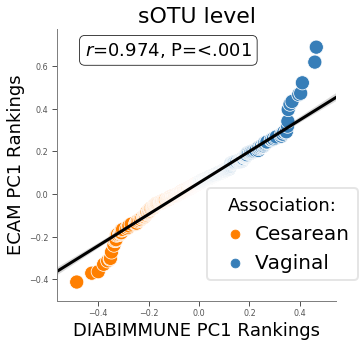

In [8]:
from scipy.stats import kendalltau
from scipy.stats import weightedtau
from scipy.stats import spearmanr, pearsonr
# set label font-sizes globally

paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 8}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

level_rankings = {}
for groupby_col in ['sOTU']:
    ecam_rankings_grouped = ecam_rankings.dropna(subset=[groupby_col]).groupby(groupby_col).sum().sort_values('ranking').dropna()
    diab_rankings_grouped = diab_rankings.dropna(subset=[groupby_col]).groupby(groupby_col).sum().sort_values('ranking').dropna()

    shared_ = list(set(ecam_rankings_grouped.index) & set(diab_rankings_grouped.index))
    diab_rankings_grouped_shared = diab_rankings_grouped.reindex(shared_).sort_values('ranking')
    ecam_rankings_grouped_shared = ecam_rankings_grouped.reindex(shared_).sort_values('ranking')
    x = diab_rankings_grouped_shared.ranking.values
    y = ecam_rankings_grouped_shared.reindex(ecam_rankings_grouped_shared.index).ranking.values
    rank_compare = pd.DataFrame([center(x * 1.2),
                                 center(y / 10)],
                                ['DIABIMMUNE','ECAM']).T
    rank_compare_save = rank_compare.copy()
    rank_compare_save['label'] = ecam_rankings_grouped_shared.index
    rank_filter = abs(np.around(rank_compare[['DIABIMMUNE','ECAM']].values).min(1)) < 0.05
    rank_compare = rank_compare[rank_filter]
    rank_filter = abs(np.around(rank_compare_save[['DIABIMMUNE','ECAM']].values).min(1)) < 0.05
    rank_compare_save = rank_compare_save[rank_filter]
    rank_compare['birth_mode'] = ['Cesarean' if i < 0 else 'Vaginal'
                                  for i in rank_compare.min(axis=1)]
    rank_compare_save['birth_mode'] = ['Cesarean' if i < 0 else 'Vaginal'
                                  for i in rank_compare_save.min(axis=1)]
    level_rankings[groupby_col] = rank_compare_save

    fig,ax = plt.subplots(1,1,figsize=(5,5))
    pallettes_ = {'Vaginal':'#377eb8',
                  'Cesarean':'#ff7f00'}

    sns.scatterplot(x='DIABIMMUNE', y='ECAM', data=rank_compare,
                    hue='birth_mode', edgecolors='none',
                    palette=pallettes_, s=200, ax=ax)
    sns.regplot(x='DIABIMMUNE', y='ECAM',
                scatter=False, color='black',
                data=rank_compare, ax=ax)
    ax.set_ylabel('ECAM PC1 Rankings',
                  fontsize=18, color='black')
    ax.set_xlabel('DIABIMMUNE PC1 Rankings',
                  fontsize=18, color='black')
    # remove all grids, backrounds etc ...
    ax.legend_.remove()        
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[1:], labels[1:],
                prop={'size':20}, loc=2, 
                handletextpad=0.00001,
                bbox_to_anchor=(0.50, 0.45),
                fancybox=True, framealpha=0.1,ncol=1
                , markerscale=1.1, facecolor="white",
                edgecolor='black')
    legend.set_title('Association:',prop={'size':18})
    legend.get_frame().set_linewidth(2)
    legend.get_frame().set_alpha(.1)

    # increase the line width in the legend 
    for line in legend.get_lines()[:]:
        line.set_linewidth(6.0)

    r, p = pearsonr(rank_compare['DIABIMMUNE'],
                     rank_compare['ECAM'])
    print(r, p )
    if 'e' not in str(p) and p < .001:
        p = '<.001'
    elif p < .001:
        p = str(p)[:4]+str(p)[str(p).index('e'):]
    else:
        p = '%.3f' % (p)

    ax.annotate("$r$=%.3f, P=%s"%(r,p),
                (.1,.9), fontsize=18,
                xycoords = 'axes fraction',
                bbox=dict(facecolor='white', alpha=.9,
                          edgecolor='black',
                          boxstyle='round,pad=.3'))
    groupby_col = groupby_col.replace('family','Family')
    ax.set_title('%s level'%(groupby_col), c='black', fontsize=22)

    # save the figure to file
    plt.savefig('../../results/compare-ranks-%s.pdf'%(groupby_col),dpi=600, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')

    plt.show()




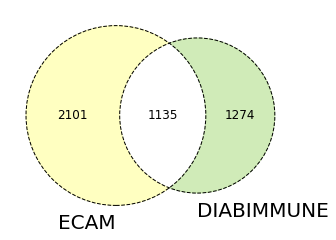

In [11]:

diab_bt = biom.load_table('../../data/DIABIMMUNE-Qiita-11884/table-matched.biom')
ecam_bt = biom.load_table('../../data/ECAM-Qiita-10249/table-matched.biom')

freq_ = ecam_bt.matrix_data.toarray().astype(bool).astype(int).sum(axis=1) / ecam_bt.shape[1]
ecam_freq = pd.DataFrame(freq_, ecam_bt.ids('observation'), ['ECAM'])
ecam_freq.index = [str(seq_dict[ind_]) for ind_ in ecam_freq.index]
freq_ = diab_bt.matrix_data.toarray().astype(bool).astype(int).sum(axis=1) / diab_bt.shape[1]
diab_freq = pd.DataFrame(freq_, diab_bt.ids('observation'), ['DIABIMMUNE'])

filt_ecam = ecam_freq.index
diab_ecam = diab_freq.index

level_ = 'sOTU'
ecam_rankings_grouped = ecam_rankings.reindex(filt_ecam).dropna(subset=[level_]).groupby(level_).sum().sort_values('ranking').dropna()
diab_rankings_grouped = diab_rankings.reindex(diab_ecam).dropna(subset=[level_]).groupby(level_).sum().sort_values('ranking').dropna()

paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 8}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

emin_, _, emax_ = ecam_rankings_grouped.ranking.quantile([.25,.5,.75])
dmin_, _, dmax_ = diab_rankings_grouped.ranking.quantile([.25,.5,.75])

ECAM_set = set(ecam_rankings_grouped.index)
DIAB_set = set(diab_rankings_grouped.index)

v = venn2([ECAM_set, DIAB_set], set_labels = ('ECAM', 'DIABIMMUNE'))

v.get_patch_by_id('100').set_alpha(.6)
v.get_patch_by_id('100').set_color('#ffff99')
label = v.get_label_by_id('100')          
label.set_fontsize(12) 

v.get_patch_by_id('010').set_alpha(.6)
v.get_patch_by_id('010').set_color('#b2df8a')
label = v.get_label_by_id('010')          
label.set_fontsize(12) 

v.get_patch_by_id('110').set_alpha(.1)
v.get_patch_by_id('110').set_color('white')
label = v.get_label_by_id('110')          
label.set_fontsize(12) 

for t in v.set_labels: t.set_fontsize(20)

c = venn2_circles(subsets = [ECAM_set,DIAB_set],
                  linewidth=1, linestyle='dashed')

# save the figure to file
plt.savefig('../../results/venn-sOTU-compare.pdf',dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.show()




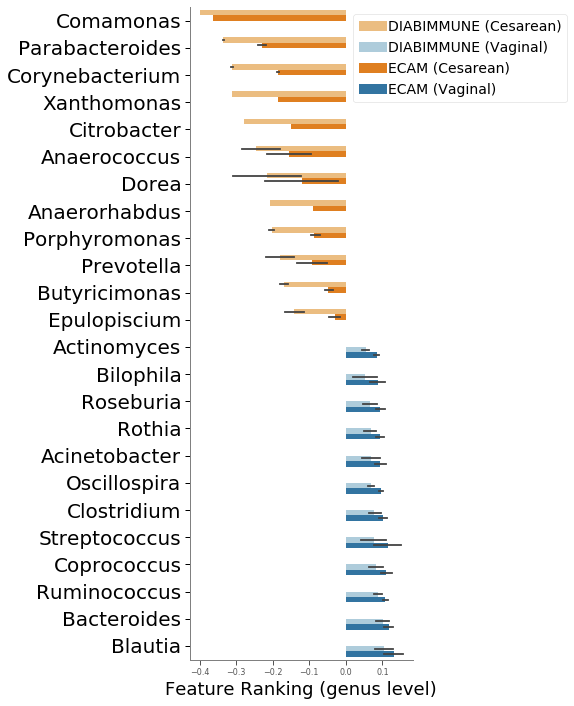

In [25]:
level_plot = 'genus'

plot_ranks = level_rankings['sOTU'].copy().reset_index()
# get tax labels 
tax_ecam_ = tax_ecam.copy()
tax_ecam_.index = [str(seq_dict[ind]) for ind in tax_ecam_.index]
tax_labels = {**dict(add_taxsplit(tax_diab)[level_plot]),
              **dict(add_taxsplit(tax_ecam_)[level_plot])}
plot_ranks['ASV'] = plot_ranks.label
plot_ranks['label'] = [tax_labels[x] for x in plot_ranks.label]
plot_ranks = plot_ranks.dropna(subset=['label'])
# remove bad strings
plot_ranks['label'] = [v.replace('[','').replace(']','') 
                       for v in plot_ranks['label']]
# seperate and rename
df1 = plot_ranks[['DIABIMMUNE', 'label','ASV']]
df1 = df1.rename({'DIABIMMUNE':'ranking'}, axis=1)
df1['study'] = 'DIABIMMUNE'
df2 = plot_ranks[['ECAM', 'label','ASV']]
df2 = df2.rename({'ECAM':'ranking'}, axis=1)
df2['study'] = 'ECAM'
# join them
join_plot_ranks = pd.concat([df1, df2])
# label them
join_plot_ranks['birth_mode'] = ['Cesarean' if i < 0 else 'Vaginal'
                         for i in join_plot_ranks['ranking']]
join_plot_ranks['grouping'] = join_plot_ranks['study'] +\
                                ' (' + join_plot_ranks['birth_mode'] + ')'
# filtered
join_plot_ranks = join_plot_ranks[~join_plot_ranks.label.isin(['ph2', '1-68','Dialister',
                                                               'rc4-4','Haemophilus', 'Coprobacillus',
                                                              'Odoribacter', 'Fusobacterium',
                                                               'Lachnoanaerobaculum'])]
join_plot_ranks_order = join_plot_ranks.groupby('label').sum().sort_values('ranking')
# quantile filter
min_, max_ = join_plot_ranks_order.ranking.quantile([0.1,0.9]).values
# get lower index
lower_label = join_plot_ranks_order.loc[(join_plot_ranks_order['ranking'] < min_)].index
join_plot_asv = join_plot_ranks.groupby('ASV').max()
lower_ASV = join_plot_asv.loc[(join_plot_asv['ranking'] < 0)].index
lower_ = join_plot_ranks[((join_plot_ranks.label.isin(lower_label))\
                         & (join_plot_ranks.ASV.isin(lower_ASV)))].index
# get upper index
upper_ = join_plot_ranks_order.loc[(join_plot_ranks_order['ranking'] > max_)].index
join_plot_asv = join_plot_ranks.groupby('ASV').min()
upper_ASV = join_plot_asv.loc[(join_plot_asv['ranking'] > 0)].index
upper_ = join_plot_ranks[((join_plot_ranks.label.isin(upper_))\
                         & (join_plot_ranks.ASV.isin(upper_ASV)))].index
keep_ = sorted(set(list(lower_) + list(upper_)))
join_plot_ranks = join_plot_ranks.loc[keep_, :]
# plot order
order_ = join_plot_ranks.groupby('label').mean().sort_values('ranking').index
order_ = {ord_:i_ for i_, ord_ in enumerate(order_)}
join_plot_ranks['order'] = [order_[v] for v in join_plot_ranks.label]

# plot
paper_rc = {'lines.linewidth': 1, 
            'lines.markersize': 1}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 20

pall_ = {'DIABIMMUNE (Cesarean)':'#fdbf6f',
         'DIABIMMUNE (Vaginal)':'#a6cee3',
         'ECAM (Cesarean)':'#ff7f00',
         'ECAM (Vaginal)':'#1f78b4'}

fig, ax = plt.subplots(1,1, figsize=(4, 12))

sns.barplot(x='ranking',
            y='label',
            hue='grouping',
            data=join_plot_ranks.sort_values('order'),
            ax=ax, palette=pall_, ci=68)
#plt.xscale('symlog', linthreshy=0.5)

# remove all grids, backrounds etc ...
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend([handles[0],handles[2],handles[1],handles[3]],
                   [labels[0],labels[2],labels[1],labels[3]]  ,
                    prop={'size':14}, loc=2, 
                    handletextpad=0.1,
                    bbox_to_anchor=(0.7, 1.),
                    fancybox=True, framealpha=0.1,ncol=1
                    , facecolor="white",
                    edgecolor='black')
ax.set_ylabel('')
ax.set_xlabel('Feature Ranking (genus level)',
              c='black',fontsize=18)
ax.yaxis.label.set_color('black')
ax.tick_params(axis='y', colors='black')

# save the figure to file
plt.savefig('../../results/genus-ranked.pdf',dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()